In [1]:
import settings as settings
import src.forecast_metrics as fm
from src.data import dataexplore as dtexp
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from src.data import datacleaner as dtclean
from src.visualization import data_visualization as dtview
from src.data import make_dataset as make_ds
from src.data import dataframegenerator as gendf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import warnings
import seaborn as sns

plt.style.use('ggplot')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

warnings.filterwarnings('ignore')

path, csvpath, imgpath, neg_values_path, large_file_path = settings.get_file_path()

# Data Processing

In [2]:
df_h_most_cli = make_ds.get_dataset(table='sisqual_all', store='40',  columns=['store','ds','n_clients']
                                    , col_to_rename='n_clients', is_client=True)
df_h_most_cli['ds'] = pd.to_datetime(df_h_most_cli['ds'])
df_h_most_cli = df_h_most_cli.set_index(pd.DatetimeIndex(df_h_most_cli['ds']))
df_h_most_cli = df_h_most_cli.between_time('10:00','13:00')
df_h_most_sales = make_ds.get_dataset(table='sisqual_all', store='40', columns=['store','ds','sales']
                                      , col_to_rename='sales', is_client=False)
df_h_most_sales['ds'] = pd.to_datetime(df_h_most_sales['ds'])
df_h_most_sales = df_h_most_sales.set_index(pd.DatetimeIndex(df_h_most_sales['ds']))
df_h_most_sales = df_h_most_sales.between_time('10:00','13:00')

In [3]:
dtview.print_dataframe_core_info(df_h_most_sales)
print('Dataframe information: {}'.format(df_h_most_sales.info()))
df_h_most_sales.describe()

+-----------------------+---------------------+--------------------+
| Sales Dataframe Start | Sales Dataframe End | Data Period Range  |
+-----------------------+---------------------+--------------------+
|  2015-01-02 10:00:00  | 2020-10-18 14:30:00 | 2116 days 04:30:00 |
+-----------------------+---------------------+--------------------+
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94314 entries, 2350436 to 2444749
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   94314 non-null  int64         
 1   store   94314 non-null  int64         
 2   ds      94314 non-null  datetime64[ns]
 3   y       94314 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.6 MB
Dataframe information: None


index    store             y
count  9.431400e+04  94314.0  94314.000000
mean   2.397592e+06     40.0    139.731047
std    2.722625e+04      0.0    351.496198
min    2.350436e+06     40.0  -7639.000000
25%    2.374014e+06     40.0     66.000000
50%    2.397592e+06     40.0    103.000000
75%    2.421171e+06     40.0    156.000000
max    2.444749e+06     40.0  24299.000000

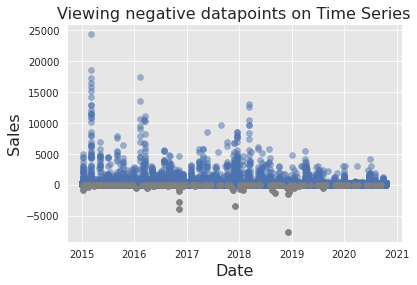

In [4]:
dtview.highlight_ts_dots(df_h_most_sales)

# Sales analysis

## Split into train and test dataframe


## Finding dataframe data points (It is how prophet defines history_size)

In [5]:
threshold_date = pd.to_datetime('2018-12-31 14:00:00')
df_sales_treino, df_sales_teste = dtexp.split_dataframe(df_h_most_sales,threshold_date=threshold_date)
make_ds.get_history_data_points(df_sales_treino, data_percentage=0.8)-1


52430

In [6]:
alpha=0.8
mdl_prophet = Prophet(growth = 'linear',
                      interval_width=alpha,
                      #changepoint_prior_scale=0.0001,
                      #holidays_prior_scale=0.01,
                      #seasonality_prior_scale=0.0001,
                      #changepoint_range=0.4,
                      seasonality_mode="additive")

#mdl_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
#mdl_prophet.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
mdl_prophet.fit(df_sales_treino)

future_sales = mdl_prophet.make_future_dataframe(periods=180, freq='30min')

future_sales['ds'] = pd.to_datetime(future_sales['ds'])
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
# Instead of adding 0 do this On the half-hourly predictions, due to the higher temporal resolution and in order to obtain better results some changes in the parameters ocurred. The changepoint_prior_scale is the regularizer of the effects that changepoints cause in the TS. Prophet assumes that the trend’s magnitude is modified at each changepoint. By leaving the default values for n_changepoint (parameter that specifies the number of changepoints), Prophet assumes a fixed value of 80% of historical data, which in the case study represents 839 changepoints in the training data set, setting the changepoint_prior_scale to a lower value, in each changepoint the trend may change in a smaller amount, therefore, less total change and less flexibility of the trend but concentrated in the same number of changepoints. on future dataframe
future_sales = future_sales.between_time('10:00','13:00')
forecast_sales = mdl_prophet.predict(future_sales)
iplot(dtview.plot_forecast_as_table(forecast_sales))

In [7]:
df_sl_tst = df_sales_teste.iloc[:forecast_sales.shape[0]]
fm.mape(np.array(df_sl_tst['y']), np.array(forecast_sales['yhat']))


327249698.3706252

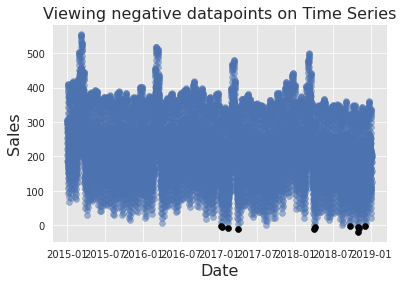

In [8]:
dtview.highlight_ts_dots(forecast_sales, threshold_values = -1, is_forecast=True)

####### Probabily the negative values forecasted are affecting the metrics also, the forecast is affected by the trend
####### an analysis over the trend can help deal with this ts behavior:

## Plotting the forecast

(<module 'matplotlib.pyplot' from '/home/clonynunes/PycharmProjects/Forecast/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>,
 <Figure size 1080x360 with 1 Axes>)

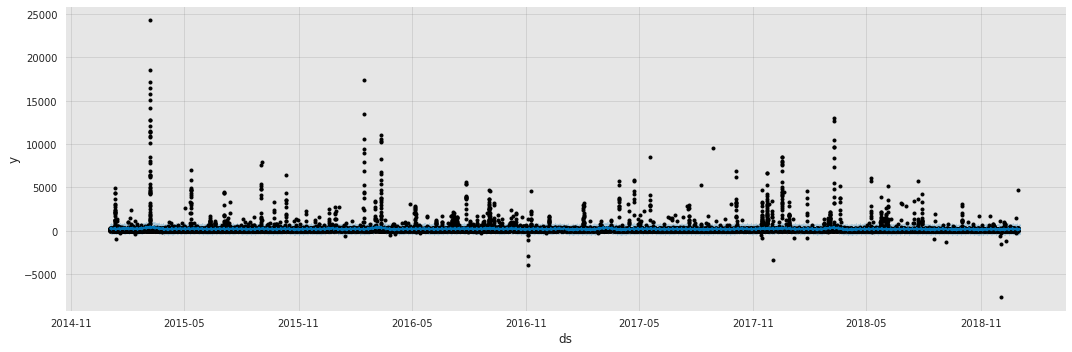

In [9]:
dtview.plot_forecast(forecast_sales, mdl_prophet)

## Investigating the odd forecast:
### Trend

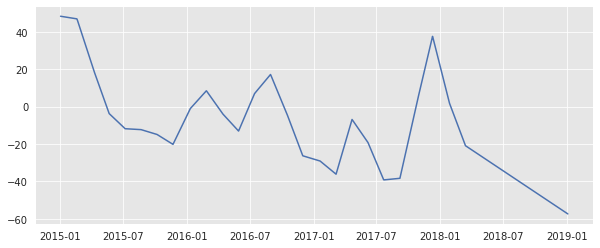

In [10]:
dtview.plot_trend(forecast_sales, mdl_prophet)

###### The negative values obtained by the forecast is due how Prophet's stan model forecasts based upon the trend
###### component. Thou as this component is negative, as shown by the above figure, there will be some negative values
###### forecasted. Some forecasting are unnatural to have negative values, such as this case study and Prophets community
###### discuss^[https://github.com/facebook/prophet/issues/1668]. on strategies to force predictions to be positive in
###### this case and the last debate propose five options to force positive predictions, described in summary above:

## Approach 1 - Clamp negative values
###### Forcing positive predictions is likely to lead to the use of multiplicative seasonality, so the principle of this
###### approach is to adjust a common model and clamp negative predictions to 0.

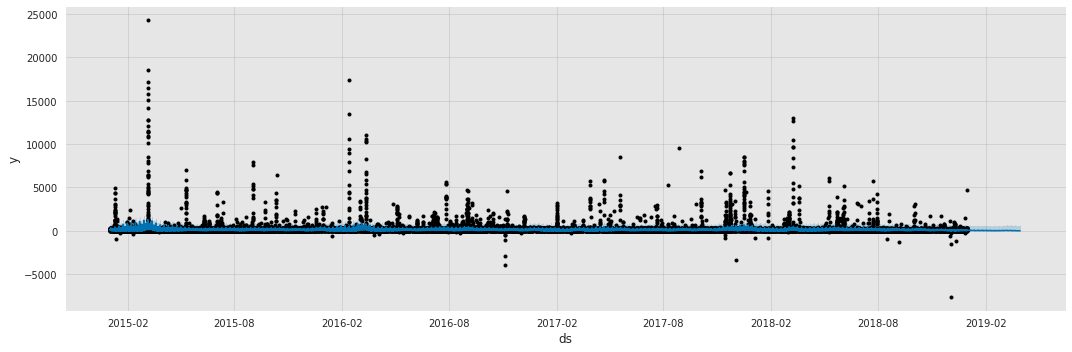

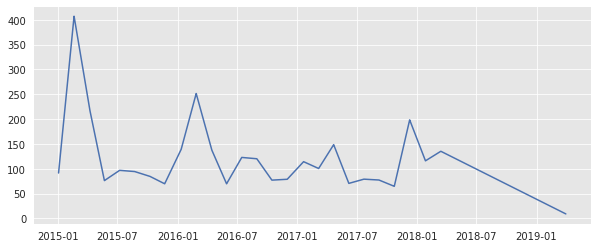

In [11]:
# Fit a usual prophet model, and clip
fcst, common_model = dtexp.clip_trend(df_sales_treino)
dtview.plot_forecast(fcst, common_model)
dtview.plot_trend(fcst, common_model)

###### From the image above, it is possible to see that the approach to fixing the negative value was not effective

## Approach 2 - Logistic growth
###### As the logistic growth trend has a default floor at 0, it ensures that the trend stays positive although it
###### can ensure that the forecasts will be positive, it also requires specifying a CAP (carrying capacity) which is a
###### maximum saturation value. Also cthe seasonality can push the prediction values to negative, in order to prevent
###### this to happen, this approach also clip to 0, just as the approach 1.

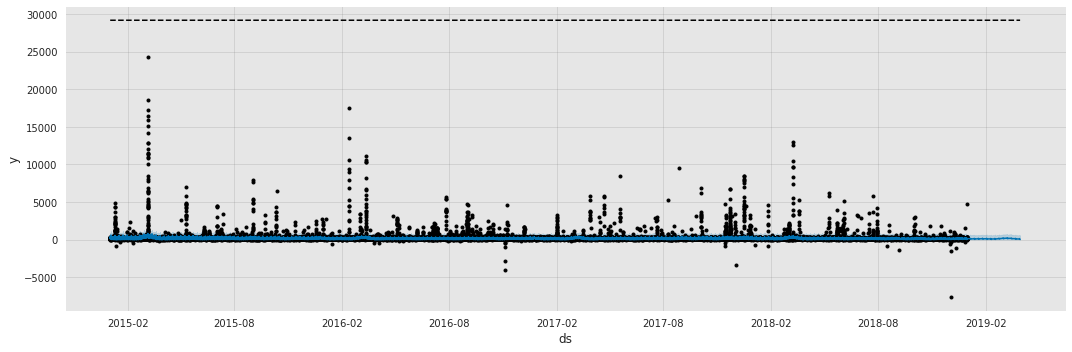

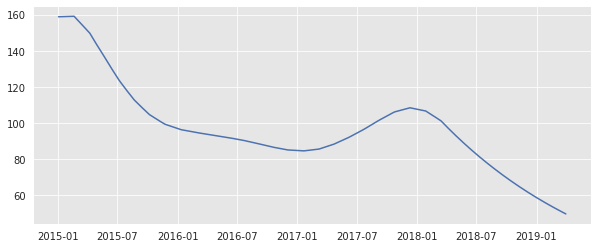

In [12]:
# Fit a logistic growth model, and clip
fcst, common_model_logistic = dtexp.apply_logistc_growth(df_sales_treino)
dtview.plot_forecast(fcst, common_model_logistic)
dtview.plot_trend(fcst, common_model_logistic)

###### As stablished on the related paper ^[https://facebook.github.io/prophet/docs/saturating_forecasts.html] the
###### logistic growth trend has the purpose to saturate at 0 and that is done.

# Approach 3 - Log transform

###### log transforming `y` and then making the forecast and take the `exp` of this forecast guarantee the positive wanted.
###### This approach changes the nature of the seasonality as the additive seasonality in the log transform space correspond
###### to multiplicative seasonality in the original space^[https://github.com/facebook/prophet/issues/647#issuecomment-413027578].


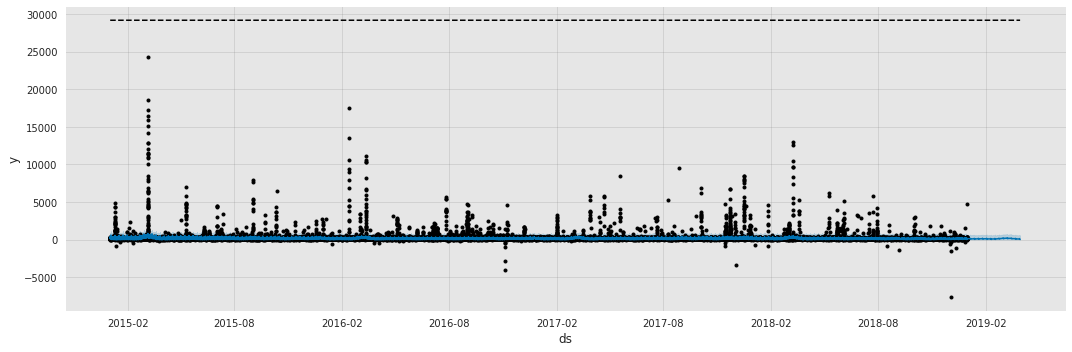

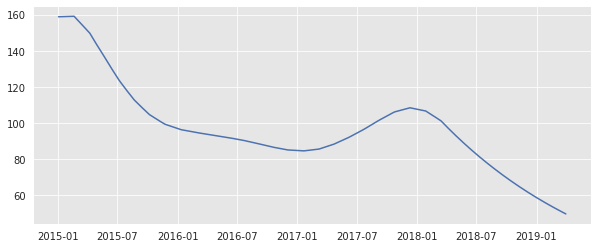

In [13]:
dtexp.apply_log_transform(df_sales_treino)
dtview.plot_forecast(fcst, common_model)
dtview.plot_trend(fcst, common_model)

###### The plot shows that there is a trend uncertainty and it is all being squashed out by the `exp` inverse tranform,
###### also the `exp` inverse can produce numerical issues such as infinite value error.

## Approach 4 - Negative binomial or Poisson likelihood
###### Due to the several discussion around the use of negative binomial or Poisson likelihood instead of the Gaussian
###### likelihood there were created a prototype to handle count data using negative binomial or Poisson likelihood
###### as well.

In [14]:
dtexp.apply_negative_binomial(df_sales_treino)

__init__() got an unexpected keyword argument 'likelihood'


###### Not implemented yet

## Approach 5 - Positivize the trend model

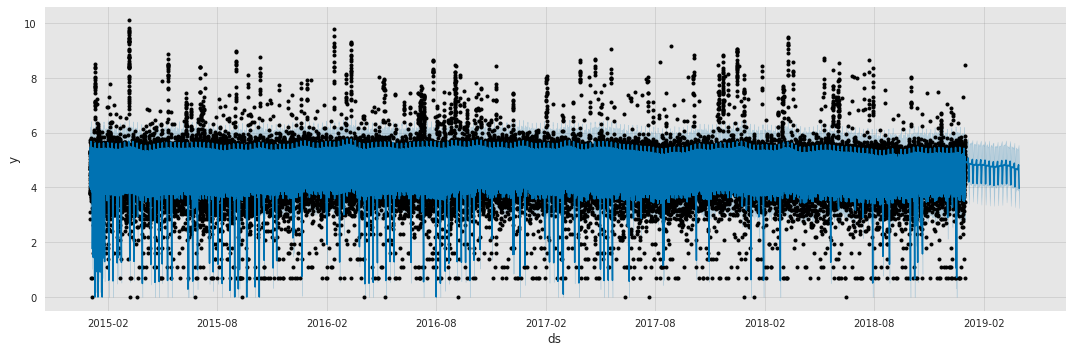

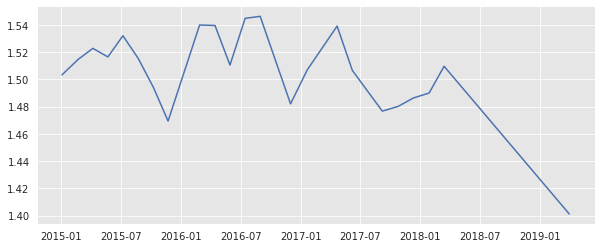

In [15]:
fcst, model = dtexp.make_forecast_positive(df_sales_treino)
dtview.plot_forecast(fcst, model, 'positivize_forecast_')
dtview.plot_trend(fcst, model, with_changepoints=False, filename='positivize_trend_')

As Prophet trend is a piecewise linear function, it is not possible to prevent negative trends, and simply clamping it  to 0 eliminates all of the future trend uncertainty. Trend uncertainty is estimated with Monte Carlo sampling, by sampling future trends with the following simulation:

At each future time, sample whether or not there will be a trend change from a Poisson distribution (whose rate is estimated during model fitting). If there is a trend change, sample the magnitude of the trend change from a Laplace distribution (whose scale is estimated during model fitting). Update the trend with that change, and continue forward in time. This procedure is described in Section 3.1.4 of the paper^[https://peerj.com/preprints/3190.pdf]. Suppose that the generative model is modified to disallow trend changes that take the trend negative. Basically, when simulating a future trend, when it hits 0 instead starts to go negative, add a new trend change that keeps it at 0. Then, positive future trend changes will still be able to take the trend positive again (it isn't stuck below 0 like with clipping approaches), and negative future trend changes will simply have no effect. This can be implemented by modifying the function that Prophet uses for calculating the piecewise linear trend.

With this model, the trend has the possibility to become positive again. It also avoids some of the downsides of other approaches: there is no requirement to specify a cap, and there are no numerically-unstable transforms.

To summup in settings where the trend saturates to 0 and it is not expected it to come back up, the simplest approach of fitting a default model and clipping to 0 (approach 1) may be the best. Logistic growth, log transform, and NB likelihood all come with potential for issues and didn't really do anything better than simple clipping here. If the trend may come back up, then only the ProphetPos approach can capture that well.

In [21]:
print(df_sales_treino.query('y == 0').count())

tamanho treino: 
65539
nan
nan


In [ ]:
print('tamanho treino: \n{}'.format(df_sales_treino.shape[0]))
if df_sales_treino.shape[0] < fcst.shape[0]:
    fcst = fcst.iloc[:df_sales_treino.shape[0]]
else: 
    df_sl_tst = df_sales_treino.iloc[:fcst.shape[0]]

print(fm.mape(np.array(df_sl_tst['y']), np.array(fcst['yhat'])))
print(fm.rmse(np.array(df_sl_tst['y']), np.array(fcst['yhat'])))

# Sales analysis
### Is there negative sales?
#### Which Hour has more negative values?  Why? Is that important?

In [ ]:
dtview.plot_negative_values(df_h_most_sales, filename='40_negative_sales_', by_hour=True)

#### Which day has more negative values?  Why? Is that important?

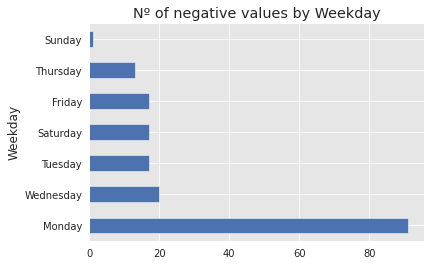

In [5]:
dtview.plot_negative_values(df_h_most_sales, filename='40_negative_sales_', by_day=True)

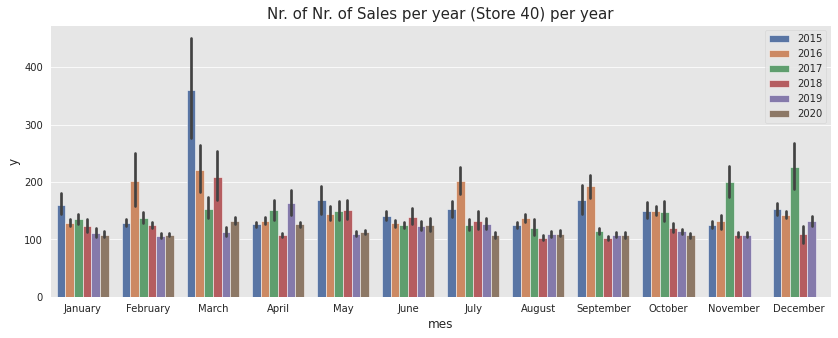

In [6]:
(dtview.plot_nr_of_y_per_year(df_h_most_sales, "Nr. of Sales per year (Store 40)")).show()

#### Which month has more negative sells. Why? Is that important?

In [ ]:
dtview.plot_negative_values(df_h_most_sales, filename='40_negative_sales_', by_month=True)

####### The strategy adopted in relation to negative values is:
 + Remove negative sales from the data set, since they can be accounting adjustments related to product returns or some other adjustment that is unlikely to affect the quantity of products sold;
 + Use ProphetPos class to adjust trend without affects future trend calculation

## Split dataframe

In [ ]:
df_sales = dtexp.zeroes_negative_values(df_h_most_sales, 'y')
df_sales.drop(columns='index', inplace=True)
df_sales = dtexp.resample_dataframe(df_sales, '30min')
threshold_date = pd.to_datetime('2018-12-31 14:00:00')
df_sales_treino, df_sales_teste = dtexp.split_dataframe(df_sales,threshold_date=threshold_date)

## Initial forecasts

In [ ]:
alpha=0.8
mdl_prophet = Prophet(growth = 'linear',
                      interval_width=alpha,
                      #changepoint_prior_scale=0.0001,
                      #holidays_prior_scale=0.01,
                      #seasonality_prior_scale=0.0001,
                      #changepoint_range=0.4,
                      seasonality_mode="multiplicative")

#mdl_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.7)
#mdl_prophet.add_seasonality(name='daily', period=1, fourier_order=3, prior_scale=0.7)
mdl_prophet.fit(df_sales_treino)

future_sales = mdl_prophet.make_future_dataframe(periods=180, freq='30min')

future_sales['ds'] = pd.to_datetime(future_sales['ds'])
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
future_sales = future_sales.set_index(pd.DatetimeIndex(future_sales['ds']))
# Instead of adding 0 do this On the half-hourly predictions, due to the higher temporal resolution and in order to obtain better results some changes in the parameters ocurred. The changepoint_prior_scale is the regularizer of the effects that changepoints cause in the TS. Prophet assumes that the trend’s magnitude is modified at each changepoint. By leaving the default values for n_changepoint (parameter that specifies the number of changepoints), Prophet assumes a fixed value of 80% of historical data, which in the case study represents 839 changepoints in the training data set, setting the changepoint_prior_scale to a lower value, in each changepoint the trend may change in a smaller amount, therefore, less total change and less flexibility of the trend but concentrated in the same number of changepoints. on future dataframe
future_sales = future_sales.between_time('10:00','13:00')
forecast_sales = mdl_prophet.predict(future_sales)
iplot(dtview.plot_forecast_as_table(forecast_sales))

In [ ]:
df_sl_tst = df_sales_teste.iloc[:forecast_sales.shape[0]]
print(fm.mape(np.array(df_sl_tst['y']), np.array(forecast_sales['yhat'])))
print(fm.rmse(np.array(df_sl_tst['y']), np.array(forecast_sales['yhat'])))

###### Removing negative values from forcast dataframe using positivize_model

In [ ]:
fcst, mdl = dtexp.make_forecast_positive(df_sales_treino, periods=180, freq='30min')
if fcst.shape[0] > df_sales_treino.shape[0]:
    fcst_test = fcst.iloc[:df_sales_teste.shape[0]]
    print(fm.mape(np.array(df_sales_teste['y']), np.array(fcst_test['yhat'])))
    print(fm.rmse(np.array(df_sales_teste['y']), np.array(fcst_test['yhat'])))
else:
    df_sl_tst = df_sales_treino.iloc[:fcst.shape[0]]
    print(fm.mape(np.array(df_sl_tst['y']), np.array(fcst['yhat'])))
    print(fm.rmse(np.array(df_sl_tst['y']), np.array(fcst['yhat'])))